# **NYC Motor Vehicle Crash Predictions**

**Poisson Regression Model**

#**Objective**

Build a regression model and determine which variables build the best model to predict the probability of a vehicle crash.




#**Data Summary**



### **NYC MOTOR VEHICLE COLLISIONS – CRASHES**

- **Source:** https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data
- **Description:** The Motor Vehicle Collisions crash table contains details on the crash event. Each row represents a crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. The police report (MV104-AN) is required to be filled out for collisions where someone is injured or killed, or where there is at least $1000 worth of damage.
- **Size:** 2,212,912 rows, 29 columns
- **Date Range:** *2012-07-01 to 2025-10-11*



In [ ]:
# nyc car crash data upload from drive

from google.colab import drive
drive.mount('/content/drive')

!pip install pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("NYC_Crash_Analysis") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

file_path = '/content/drive/MyDrive/IST 718 - Big Data Analytics (Group Projects)/nyc_crash_data.parquet'
spark_df = spark.read.parquet(file_path)

spark_df.cache()

print(f"✓ Loaded into PySpark")
print(f"✓ Total rows: {spark_df.count():,}")
print("\nSchema:")
spark_df.printSchema()
print("\nFirst 5 rows:")
spark_df.show(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Loaded into PySpark
✓ Total rows: 2,212,912

Schema:
root
 |-- crash_date: string (nullable = true)
 |-- crash_time: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- human_address: string (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- cross_street_name: string (nullable = true)
 |-- number_of_persons_injured: string (nullable = true)
 |-- number_of_persons_killed: string (nullable = true)
 |-- number_of_pedestrians_injured: string (nullable = true)
 |-- number_of_pedestrians_killed: string (nullable = true)
 |-- number_of_cyclist_injured: string (nullable = true)
 |-- number_of_cyclist_killed: string (nullabl

In [ ]:
# rename df

df_collisions = spark_df

# confirm date range of crash dates; find min and max dates
from pyspark.sql.functions import min, max

df_collisions.select(
    min('crash_date').alias('Earliest_Date'),
    max('crash_date').alias('Latest_Date')
).show()

+--------------------+--------------------+
|       Earliest_Date|         Latest_Date|
+--------------------+--------------------+
|2012-07-01T00:00:...|2025-10-11T00:00:...|
+--------------------+--------------------+



### **Weather Data**

- **Source:** https://www.visualcrossing.com/
- **Description:** Visual Crossing is a comprehensive weather data platform that delivers historical and forecast meteorological information through their Timeline Weather API. This analysis incorporates hourly weather observations for New York City with variables including temperature, precipitation, humidity, wind conditions, and visibility to assess the relationship between weather patterns and motor vehicle collision occurrence.
- **Size:**  116,424 rows, 24 columns
- **Date Range:** *2012-07-01 to 2025-10-11*


In [ ]:
# weather data upload from drive

from pyspark.sql.functions import to_timestamp, col

spark = SparkSession.builder \
    .appName("NYC_Weather_Analysis") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

weather_path = '/content/drive/MyDrive/IST 718 - Big Data Analytics (Group Projects)/nyc_weather_data_2012_2025.parquet'
weather_df = spark.read.parquet(weather_path)

weather_df = weather_df.withColumn(
    'datetime',
    to_timestamp(col('datetime'), 'yyyy-MM-dd HH:mm:ss')
)

weather_df.cache()

print(f"✓ Weather Data Loaded into PySpark")
print(f"Total rows: {weather_df.count():,}")
print("\nSchema:")
weather_df.printSchema()
print("\nFirst 10 rows:")
weather_df.show(10, truncate=False)

# confirm date range
from pyspark.sql.functions import min, max
weather_df.select(
    min('datetime').alias('Earliest'),
    max('datetime').alias('Latest')
).show()


✓ Weather Data Loaded into PySpark
Total rows: 116,424

Schema:
root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- precipprob: double (nullable = true)
 |-- preciptype: string (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- solarradiation: double (nullable = true)
 |-- solarenergy: double (nullable = true)
 |-- uvindex: double (nullable = true)
 |-- conditions: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- severerisk

# **Data Exploration**

### Crash Data Review

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count
import pandas as pd


print("Checking for missing values and data types in each column:\n")

from pyspark.sql.functions import sum as spark_sum, when

null_counts = df_collisions.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_collisions.columns
])

null_counts_pd = null_counts.toPandas().T
null_counts_pd.columns = ['Null_Count']

data_types = {field.name: field.dataType.simpleString() for field in df_collisions.schema.fields}
data_types_pd = pd.DataFrame.from_dict(data_types, orient='index', columns=['Data_Type'])

summary_df = pd.concat([data_types_pd, null_counts_pd], axis=1)
summary_df.index.name = 'Column_Name'

print(summary_df)
print(f"\nTotal Columns: {len(summary_df)}")
print(f"Total Rows: {df_collisions.count():,}")


Checking for missing values and data types in each column:

                                                                       Data_Type  \
Column_Name                                                                        
crash_date                                                                string   
crash_time                                                                string   
borough                                                                   string   
zip_code                                                                  string   
latitude                                                                  string   
longitude                                                                 string   
location                       struct<human_address:string,latitude:string,lo...   
cross_street_name                                                         string   
number_of_persons_injured                                                 string   
number_of_person

In [ ]:
# clean up data type in crash data

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType, DateType, TimestampType

print("Converting columns to appropriate data types...")

df_collisions_cleaned = df_collisions \
    .withColumn('zip_code', col('zip_code').cast(IntegerType())) \
    .withColumn('latitude', col('latitude').cast(DoubleType())) \
    .withColumn('longitude', col('longitude').cast(DoubleType())) \
    .withColumn('number_of_persons_injured', col('number_of_persons_injured').cast(IntegerType())) \
    .withColumn('number_of_persons_killed', col('number_of_persons_killed').cast(IntegerType())) \
    .withColumn('number_of_pedestrians_injured', col('number_of_pedestrians_injured').cast(IntegerType())) \
    .withColumn('number_of_pedestrians_killed', col('number_of_pedestrians_killed').cast(IntegerType())) \
    .withColumn('number_of_cyclist_injured', col('number_of_cyclist_injured').cast(IntegerType())) \
    .withColumn('number_of_cyclist_killed', col('number_of_cyclist_killed').cast(IntegerType())) \
    .withColumn('number_of_motorist_injured', col('number_of_motorist_injured').cast(IntegerType())) \
    .withColumn('number_of_motorist_killed', col('number_of_motorist_killed').cast(IntegerType())) \
    .withColumn('collision_id', col('collision_id').cast(IntegerType()))

df_collisions = df_collisions_cleaned

print("✓ Data types converted successfully!\n")

print("Updated Schema:")
df_collisions.printSchema()

# summarize data types
import pandas as pd
from pyspark.sql.functions import sum as spark_sum, when

# check null
null_counts = df_collisions.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_collisions.columns
])

null_counts_pd = null_counts.toPandas().T
null_counts_pd.columns = ['Null_Count']

# show new data types
data_types = {field.name: field.dataType.simpleString() for field in df_collisions.schema.fields}
data_types_pd = pd.DataFrame.from_dict(data_types, orient='index', columns=['Data_Type'])

summary_df = pd.concat([data_types_pd, null_counts_pd], axis=1)
summary_df.index.name = 'Column_Name'

print("\nColumn Summary (Updated Data Types):")
print(summary_df)


Converting columns to appropriate data types...
✓ Data types converted successfully!

Updated Schema:
root
 |-- crash_date: string (nullable = true)
 |-- crash_time: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- human_address: string (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- cross_street_name: string (nullable = true)
 |-- number_of_persons_injured: integer (nullable = true)
 |-- number_of_persons_killed: integer (nullable = true)
 |-- number_of_pedestrians_injured: integer (nullable = true)
 |-- number_of_pedestrians_killed: integer (nullable = true)
 |-- number_of_cyclist_injured: integer (nullable = true)
 |-- number_of_cyclist_killed: integer (nullable = true)
 |-- number_of_motorist_injured: integer (nullable = true)
 |-- n

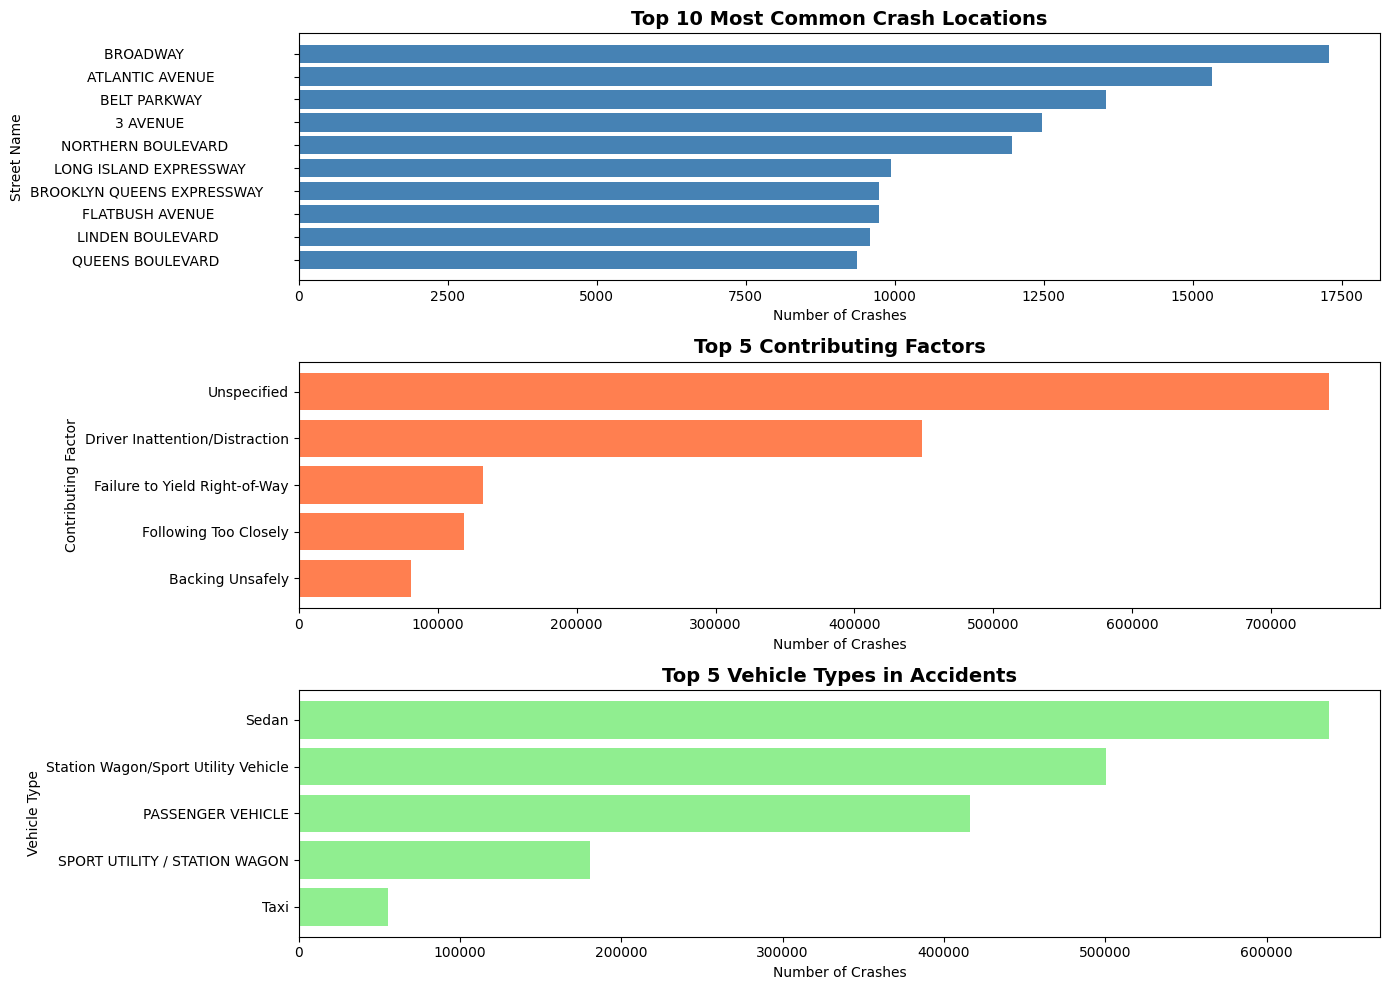

In [ ]:
# plot
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count

plt.figure(figsize=(14, 10))

# PLOT 1: Top 10 Crash Locations
plt.subplot(3, 1, 1)
top_streets = df_collisions.filter(col('on_street_name').isNotNull()) \
    .groupBy('on_street_name') \
    .count() \
    .orderBy('count', ascending=False) \
    .limit(10) \
    .toPandas()

plt.barh(top_streets['on_street_name'], top_streets['count'], color='steelblue')
plt.title('Top 10 Most Common Crash Locations', fontsize=14, fontweight='bold')
plt.xlabel('Number of Crashes')
plt.ylabel('Street Name')
plt.gca().invert_yaxis()

# PLOT 2: Top 5 Contributing Factors
plt.subplot(3, 1, 2)
top_factors = df_collisions.filter(col('contributing_factor_vehicle_1').isNotNull()) \
    .groupBy('contributing_factor_vehicle_1') \
    .count() \
    .orderBy('count', ascending=False) \
    .limit(5) \
    .toPandas()

plt.barh(top_factors['contributing_factor_vehicle_1'], top_factors['count'], color='coral')
plt.title('Top 5 Contributing Factors', fontsize=14, fontweight='bold')
plt.xlabel('Number of Crashes')
plt.ylabel('Contributing Factor')
plt.gca().invert_yaxis()

# PLOT 3: Top 5 Vehicle Types
plt.subplot(3, 1, 3)
top_vehicles = df_collisions.filter(col('vehicle_type_code1').isNotNull()) \
    .groupBy('vehicle_type_code1') \
    .count() \
    .orderBy('count', ascending=False) \
    .limit(5) \
    .toPandas()

plt.barh(top_vehicles['vehicle_type_code1'], top_vehicles['count'], color='lightgreen')
plt.title('Top 5 Vehicle Types in Accidents', fontsize=14, fontweight='bold')
plt.xlabel('Number of Crashes')
plt.ylabel('Vehicle Type')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


Number of Accidents by Year:
+----+------+
|year| count|
+----+------+
|2012|100545|
|2013|203742|
|2014|206046|
|2015|217707|
|2016|229831|
|2017|231007|
|2018|231564|
|2019|211486|
|2020|112917|
|2021|110557|
|2022|103886|
|2023| 96606|
|2024| 91309|
|2025| 65709|
+----+------+



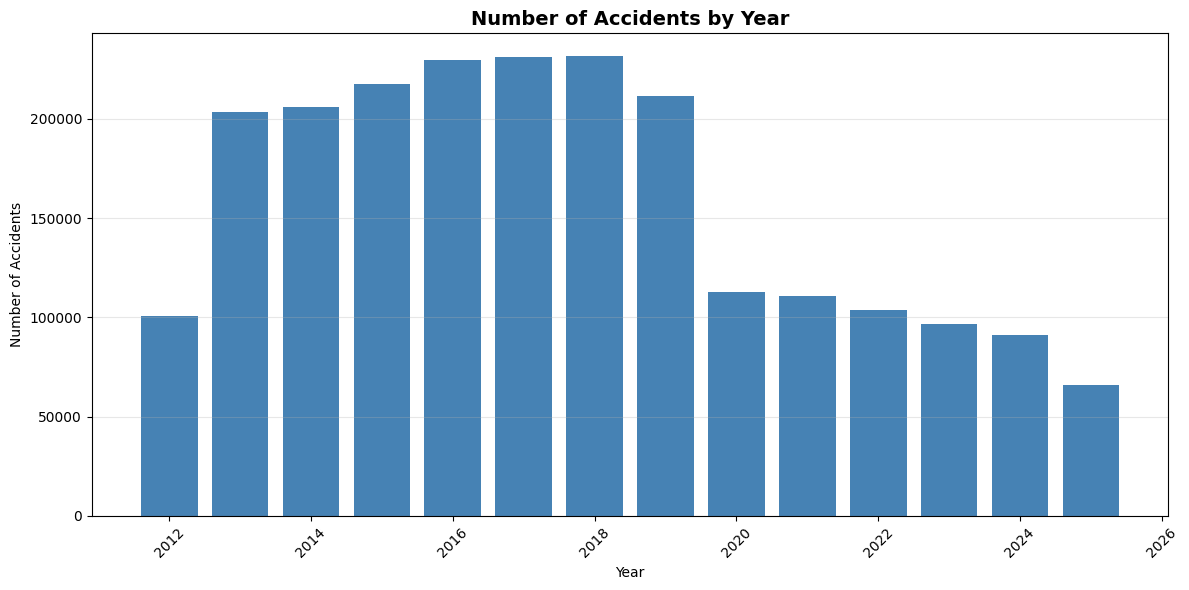

Total accidents: 2,212,912
Year with most accidents: 2018
Year with least accidents: 2025


In [ ]:
#Number of Accidents by Year

from pyspark.sql.functions import year, count

accidents_by_year = df_collisions.groupBy(year('crash_date').alias('year')) \
    .count() \
    .orderBy('year')

print("Number of Accidents by Year:")
accidents_by_year.show()

accidents_by_year = df_collisions.groupBy(year('crash_date').alias('year')) \
    .count() \
    .orderBy('year') \
    .toPandas()

# Plot Accidents per Year
plt.figure(figsize=(12, 6))
plt.bar(accidents_by_year['year'], accidents_by_year['count'], color='steelblue')
plt.title('Number of Accidents by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total accidents: {accidents_by_year['count'].sum():,}")
print(f"Year with most accidents: {accidents_by_year.loc[accidents_by_year['count'].idxmax(), 'year']}")
print(f"Year with least accidents: {accidents_by_year.loc[accidents_by_year['count'].idxmin(), 'year']}")

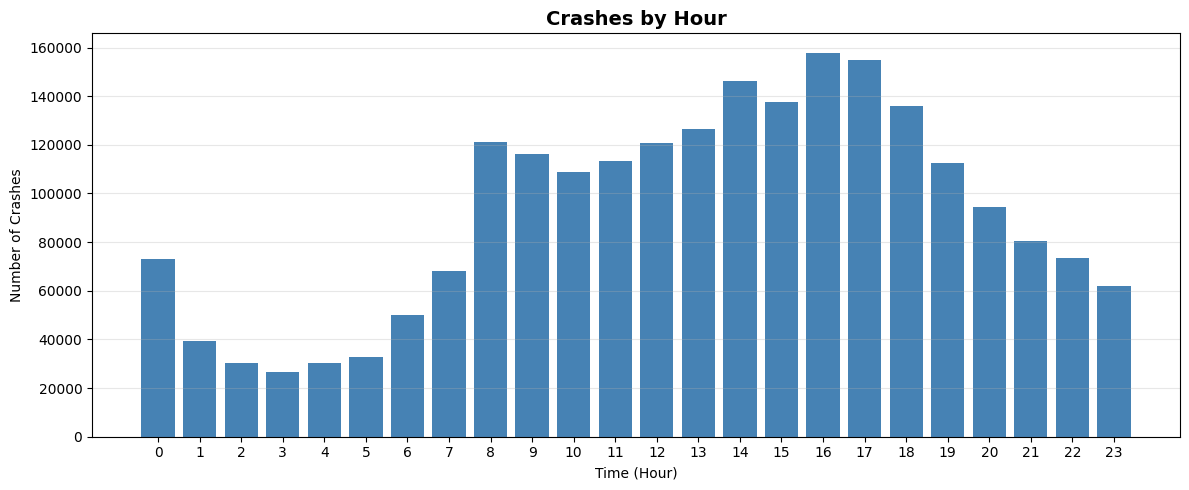

In [ ]:
# Total Crashes by the hour for entire dataset

from pyspark.sql.functions import hour, to_timestamp, concat, lit, col
import matplotlib.pyplot as plt

crashes_by_hour = df_collisions.withColumn('hour', hour('crash_time')) \
    .groupBy('hour') \
    .count() \
    .orderBy('hour') \
    .toPandas()

# Plot
plt.figure(figsize=(12, 5))
plt.bar(crashes_by_hour['hour'], crashes_by_hour['count'], color='steelblue')
plt.xlabel('Time (Hour)')
plt.ylabel('Number of Crashes')
plt.title('Crashes by Hour', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Weather Data Review

In [ ]:
# show null counts and data types

import pandas as pd
from pyspark.sql.functions import sum as spark_sum, when, col

null_counts = weather_df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in weather_df.columns
])

null_counts_pd = null_counts.toPandas().T
null_counts_pd.columns = ['Null_Count']

data_types = {field.name: field.dataType.simpleString() for field in weather_df.schema.fields}
data_types_pd = pd.DataFrame.from_dict(data_types, orient='index', columns=['Data_Type'])

summary_df = pd.concat([data_types_pd, null_counts_pd], axis=1)
summary_df.index.name = 'Column_Name'

print(summary_df)

print(f"\nTotal Rows: {weather_df.count():,}")
print(f"Total Columns: {len(weather_df.columns)}")

weather_df.show(20, truncate=False)

                Data_Type  Null_Count
Column_Name                          
date               string           0
time               string           0
datetime        timestamp           0
temp               double           0
feelslike          double           0
humidity           double           0
dew                double           0
precip             double           0
precipprob         double           0
preciptype         string      103512
snow               double           0
snowdepth          double           0
windspeed          double           0
windgust           double       34822
winddir            double           0
pressure           double           0
visibility         double           0
cloudcover         double           0
solarradiation     double       29709
solarenergy        double       29709
uvindex            double       29709
conditions         string           0
icon               string           0
severerisk         double      112342

Total Rows:

### Crash and Weather Data Clean Up

In [ ]:
# assign a binary label to the crash row column to use in regression
# note: all crash data includes all "positive" crash occurances of various different types

from pyspark.sql.functions import lit

df_collisions_labeled = df_collisions.withColumn("crash", lit(1))

df_collisions_labeled.select(
    "crash_date",
    "crash_time",
    "borough",
    "latitude",
    "longitude",
    "crash"
).show(20, truncate=False)

+-----------------------+----------+---------+---------+----------+-----+
|crash_date             |crash_time|borough  |latitude |longitude |crash|
+-----------------------+----------+---------+---------+----------+-----+
|2021-04-13T00:00:00.000|0:00      |BROOKLYN |40.726444|-73.95233 |1    |
|2021-04-13T00:00:00.000|0:00      |BROOKLYN |40.678524|-74.0021  |1    |
|2021-04-13T00:00:00.000|0:00      |QUEENS   |40.677498|-73.8276  |1    |
|2021-04-13T00:00:00.000|0:00      |NULL     |NULL     |NULL      |1    |
|2021-04-13T00:00:00.000|0:00      |NULL     |40.877235|-73.91781 |1    |
|2021-04-13T00:00:00.000|0:00      |NULL     |40.90021 |-73.8865  |1    |
|2021-04-13T00:00:00.000|0:07      |BRONX    |40.82942 |-73.91226 |1    |
|2021-04-13T00:00:00.000|0:15      |QUEENS   |40.727432|-73.90713 |1    |
|2021-04-13T00:00:00.000|0:45      |NULL     |40.843956|-73.8978  |1    |
|2021-04-13T00:00:00.000|10:00     |BRONX    |NULL     |NULL      |1    |
|2021-04-13T00:00:00.000|10:00     |BR

In [ ]:
# clean up the date column in crash data to match the timestamp in the weather data

from pyspark.sql.functions import to_timestamp, to_date, col

df_collisions_clean_date = df_collisions.withColumn(
    "crash_date",
    to_date(
        to_timestamp(col("crash_date"), "yyyy-MM-dd'T'HH:mm:ss.SSS")
    )
)

df_collisions_clean_date.select("crash_date", "crash_time").show(20, truncate=False)




+----------+----------+
|crash_date|crash_time|
+----------+----------+
|2021-04-13|0:00      |
|2021-04-13|0:00      |
|2021-04-13|0:00      |
|2021-04-13|0:00      |
|2021-04-13|0:00      |
|2021-04-13|0:00      |
|2021-04-13|0:07      |
|2021-04-13|0:15      |
|2021-04-13|0:45      |
|2021-04-13|10:00     |
|2021-04-13|10:00     |
|2021-04-13|10:00     |
|2021-04-13|10:00     |
|2021-04-13|10:00     |
|2021-04-13|10:04     |
|2021-04-13|10:15     |
|2021-04-13|10:20     |
|2021-04-13|10:21     |
|2021-04-13|10:30     |
|2021-04-13|10:30     |
+----------+----------+
only showing top 20 rows



In [ ]:
# remove all rows in crash data that have boroughs as "null"

from pyspark.sql.functions import col

df_collisions_no_null_borough = df_collisions_clean_date.filter(
    (col("borough").isNotNull()) & (col("borough") != "NULL")
)

df_collisions_no_null_borough.select("crash_date", "crash_time", "borough").show(20, truncate=False)

# check for nulls in remaining of the data set

from pyspark.sql.functions import col, when, sum as spark_sum

null_counts = df_collisions_no_null_borough.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_collisions_no_null_borough.columns
])

null_counts.show(truncate=False)

# show null as a list

null_counts_pd = null_counts.toPandas().T
null_counts_pd.columns = ["Null_Count"]

null_list = [(col, int(null_counts_pd.loc[col, "Null_Count"])) for col in null_counts_pd.index]

for col_name, cnt in null_list:
    print(f"{col_name}: {cnt}")

# view data type in crash data

schema_summary = [(field.name, field.dataType.simpleString())
                  for field in df_collisions_no_null_borough.schema.fields]

for col_name, dtype in schema_summary:
    print(f"{col_name}: {dtype}")


+----------+----------+---------+
|crash_date|crash_time|borough  |
+----------+----------+---------+
|2021-04-13|0:00      |BROOKLYN |
|2021-04-13|0:00      |BROOKLYN |
|2021-04-13|0:00      |QUEENS   |
|2021-04-13|0:07      |BRONX    |
|2021-04-13|0:15      |QUEENS   |
|2021-04-13|10:00     |BRONX    |
|2021-04-13|10:00     |BROOKLYN |
|2021-04-13|10:00     |BROOKLYN |
|2021-04-13|10:00     |BROOKLYN |
|2021-04-13|10:04     |BROOKLYN |
|2021-04-13|10:15     |BROOKLYN |
|2021-04-13|10:20     |BRONX    |
|2021-04-13|10:21     |BRONX    |
|2021-04-13|10:30     |BROOKLYN |
|2021-04-13|10:30     |MANHATTAN|
|2021-04-13|10:30     |QUEENS   |
|2021-04-13|10:31     |QUEENS   |
|2021-04-13|10:37     |BROOKLYN |
|2021-04-13|10:52     |BROOKLYN |
|2021-04-13|11:00     |MANHATTAN|
+----------+----------+---------+
only showing top 20 rows

+----------+----------+-------+--------+--------+---------+--------+-----------------+-------------------------+------------------------+---------------------

In [ ]:
# for crash data, list all unique values in "string columns", combine crash date and crash time to match weather datetime format and make it timestamp format

from pyspark.sql.types import StringType

# Identify all string columns
string_cols = [
    f.name for f in df_collisions_no_null_borough.schema.fields
    if isinstance(f.dataType, StringType)
]

print("String columns:", string_cols)

# list unique values in each string column

from pyspark.sql.functions import col

for c in string_cols:
    print(f"\n====== Unique values in '{c}' ======")
    df_collisions_no_null_borough.select(col(c)).distinct().show(50, truncate=False)

cols_to_count = [
    c for c in string_cols
    if c not in ["crash_time", "cross_street_name"]
]

unique_counts = {}

for c in cols_to_count:
    count_val = df_collisions_no_null_borough.select(c).distinct().count()
    unique_counts[c] = count_val

import pandas as pd

unique_counts_df = pd.DataFrame(
    list(unique_counts.items()),
    columns=["column_name", "unique_value_count"]
).sort_values("unique_value_count", ascending=False)

print(unique_counts_df)


# edit crash time and make into timestamp

from pyspark.sql.functions import lpad, split, concat_ws, col

df_step_time = df_collisions_no_null_borough.withColumn(
    "crash_hour_clean",
    lpad(split(col("crash_time"), ":").getItem(0), 2, "0")
).withColumn(
    "crash_minute_clean",
    lpad(split(col("crash_time"), ":").getItem(1), 2, "0")
).withColumn(
    "crash_time",
    concat_ws(":", col("crash_hour_clean"), col("crash_minute_clean"))
).drop("crash_hour_clean", "crash_minute_clean")

from pyspark.sql.functions import to_timestamp, concat_ws

df_crash_final = df_step_time.withColumn(
    "crash_datetime",
    to_timestamp(
        concat_ws(" ", col("crash_date").cast("string"), col("crash_time")),
        "yyyy-MM-dd HH:mm"
    )
)

df_crash_final.select(
    "crash_date",
    "crash_time",
    "crash_datetime",
    "borough"
).show(20, truncate=False)







String columns: ['crash_time', 'borough', 'cross_street_name', 'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2', 'vehicle_type_code1', 'vehicle_type_code2', 'on_street_name', 'off_street_name', 'contributing_factor_vehicle_3', 'vehicle_type_code_3', 'contributing_factor_vehicle_4', 'vehicle_type_code_4', 'contributing_factor_vehicle_5', 'vehicle_type_code_5']

====== Unique values in 'crash_time' ======
+----------+
|crash_time|
+----------+
|0:40      |
|18:47     |
|17:58     |
|21:02     |
|18:05     |
|11:19     |
|17:35     |
|11:01     |
|17:23     |
|19:03     |
|7:56      |
|2:27      |
|1:01      |
|12:26     |
|21:46     |
|16:29     |
|12:41     |
|9:24      |
|2:12      |
|8:28      |
|10:21     |
|8:40      |
|8:23      |
|10:47     |
|2:17      |
|7:03      |
|13:56     |
|13:13     |
|13:49     |
|2:03      |
|0:29      |
|1:49      |
|18:12     |
|4:15      |
|6:15      |
|17:14     |
|2:54      |
|16:13     |
|18:09     |
|2:32      |
|9:26      |
|2:40

In [ ]:
# remove columns and simplify df

df_crash_final = df_crash_final.select(
    "crash_datetime",
    "borough",
    "zip_code"
)

df_crash_final.show(20, truncate=False)

# check unique count of zipcode column (total: 234)

unique_zip_count = df_crash_final.select("zip_code").distinct().count()
print("Unique Zipcodes:", unique_zip_count)

# remove zipcode nulls (317)

from pyspark.sql.functions import col

df_crash_final = df_crash_final.filter(col("zip_code").isNotNull())

# total rows in final dataset (final: 1,533,867 rows, initial: 2,212,912 rows)
final_row_count = df_crash_final.count()
print("Final row count:", final_row_count)

# only use crash data from 2020 - 2025

from pyspark.sql.functions import year, col

df_crash_recent = df_crash_final.filter(
    (year(col("crash_datetime")) >= 2020) &
    (year(col("crash_datetime")) <= 2025)
)

df_crash_recent_count = df_crash_recent.count()
print("Number of crash records from 2020–2025:", df_crash_recent_count)





+-------------------+---------+--------+
|crash_datetime     |borough  |zip_code|
+-------------------+---------+--------+
|2021-04-13 00:00:00|BROOKLYN |11222   |
|2021-04-13 00:00:00|BROOKLYN |11231   |
|2021-04-13 00:00:00|QUEENS   |11420   |
|2021-04-13 00:07:00|BRONX    |10456   |
|2021-04-13 00:15:00|QUEENS   |11378   |
|2021-04-13 10:00:00|BRONX    |10463   |
|2021-04-13 10:00:00|BROOKLYN |11207   |
|2021-04-13 10:00:00|BROOKLYN |11209   |
|2021-04-13 10:00:00|BROOKLYN |11203   |
|2021-04-13 10:04:00|BROOKLYN |11236   |
|2021-04-13 10:15:00|BROOKLYN |11231   |
|2021-04-13 10:20:00|BRONX    |10459   |
|2021-04-13 10:21:00|BRONX    |10461   |
|2021-04-13 10:30:00|BROOKLYN |11223   |
|2021-04-13 10:30:00|MANHATTAN|10019   |
|2021-04-13 10:30:00|QUEENS   |11360   |
|2021-04-13 10:31:00|QUEENS   |11378   |
|2021-04-13 10:37:00|BROOKLYN |11207   |
|2021-04-13 10:52:00|BROOKLYN |11220   |
|2021-04-13 11:00:00|MANHATTAN|10001   |
+-------------------+---------+--------+
only showing top

In [ ]:
# remove unwanted columns from weather data set

weather_columns_to_keep = [
    "datetime",
    "temp",
    "feelslike",
    "humidity",
    "dew",
    "precip",
    "snow",
    "snowdepth",
    "windspeed",
    "winddir",
    "pressure",
    "visibility",
    "cloudcover",
    "conditions"
]

weather_df_trimmed = weather_df.select(weather_columns_to_keep)

weather_df_trimmed.show(20, truncate=False)

# show and count unique values in the "conditions" and "icon" columns

from pyspark.sql.functions import col

unique_conditions = weather_df_trimmed.select("conditions").distinct().count()

print("Unique 'conditions':", unique_conditions)

weather_df_trimmed.select("conditions").distinct().orderBy("conditions").show(100, truncate=False)


+-------------------+----+---------+--------+----+------+----+---------+---------+-------+--------+----------+----------+----------------+
|datetime           |temp|feelslike|humidity|dew |precip|snow|snowdepth|windspeed|winddir|pressure|visibility|cloudcover|conditions      |
+-------------------+----+---------+--------+----+------+----+---------+---------+-------+--------+----------+----------+----------------+
|2012-07-01 00:00:00|81.0|82.6     |56.68   |64.2|0.0   |0.0 |0.0      |8.2      |278.0  |1008.5  |9.9       |10.5      |Clear           |
|2012-07-01 01:00:00|79.6|79.6     |57.42   |63.2|0.0   |0.0 |0.0      |7.9      |275.0  |1008.5  |9.9       |0.0       |Clear           |
|2012-07-01 02:00:00|78.7|78.7     |59.01   |63.2|0.0   |0.0 |0.0      |5.3      |266.0  |1008.7  |9.9       |0.0       |Clear           |
|2012-07-01 03:00:00|77.8|77.8     |60.09   |62.9|0.0   |0.0 |0.0      |4.4      |275.0  |1008.6  |9.9       |0.0       |Clear           |
|2012-07-01 04:00:00|77.1|7

### Join Weather and Crash Dataset

In [ ]:

from pyspark.sql.functions import (
    col, year, date_trunc, minute, when, expr, broadcast
)

# show filter crashes to 2020–2025
df_crash_recent = df_crash_final.filter(
    (year(col("crash_datetime")) >= 2020) &
    (year(col("crash_datetime")) <= 2025)
)

# rename weather datetime -> weather_datetime
weather = weather_df_trimmed.withColumnRenamed("datetime", "weather_datetime")

# calculate nearest hour for each crash
#    - floor to the hour
#    - if minute < 30 -> use floor
#    - if minute >= 30 -> use floor + 1 hour

crash_with_nearest_hour = (
    df_crash_recent
    .withColumn("crash_hour_floor", date_trunc("hour", col("crash_datetime")))
    .withColumn(
        "crash_nearest_hour",
        when(
            minute(col("crash_datetime")) < 30,
            col("crash_hour_floor")
        ).otherwise(
            expr("crash_hour_floor + INTERVAL 1 HOUR")
        )
    )
    .drop("crash_hour_floor")
)

# join on nearest hour
nearest_weather = crash_with_nearest_hour.join(
    broadcast(weather),
    crash_with_nearest_hour.crash_nearest_hour == weather.weather_datetime,
    "left"
)

nearest_weather.show(20, truncate=False)



+-------------------+---------+--------+-------------------+-------------------+----+---------+--------+----+------+----+---------+---------+-------+--------+----------+----------+--------------+
|crash_datetime     |borough  |zip_code|crash_nearest_hour |weather_datetime   |temp|feelslike|humidity|dew |precip|snow|snowdepth|windspeed|winddir|pressure|visibility|cloudcover|conditions    |
+-------------------+---------+--------+-------------------+-------------------+----+---------+--------+----+------+----+---------+---------+-------+--------+----------+----------+--------------+
|2021-04-13 00:00:00|BROOKLYN |11222   |2021-04-13 00:00:00|2021-04-13 00:00:00|46.3|43.8     |90.99   |43.8|0.023 |0.0 |0.0      |5.1      |44.0   |1014.1  |7.4       |100.0     |Rain, Overcast|
|2021-04-13 00:00:00|BROOKLYN |11231   |2021-04-13 00:00:00|2021-04-13 00:00:00|46.3|43.8     |90.99   |43.8|0.023 |0.0 |0.0      |5.1      |44.0   |1014.1  |7.4       |100.0     |Rain, Overcast|
|2021-04-13 00:00:00

In [ ]:
# show new dataset row count (398,266 rows)

nearest_weather_count = nearest_weather.count()
print("Total rows in nearest_weather:", nearest_weather_count)


# count null values (22 in each of the weather data columns)

from pyspark.sql.functions import col, sum as spark_sum

null_counts = nearest_weather.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in nearest_weather.columns
])

null_counts.show(truncate=False)

# drop nulls

nearest_weather_clean = nearest_weather.dropna()

null_counts1 = nearest_weather_clean.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in nearest_weather_clean.columns
])

null_counts1.show(truncate=False)

# final row count: 398,244
nearest_weather_clean_count = nearest_weather_clean.count()
print("Total rows in nearest_weather_clean:", nearest_weather_clean_count)

Total rows in nearest_weather: 398266
+--------------+-------+--------+------------------+----------------+----+---------+--------+---+------+----+---------+---------+-------+--------+----------+----------+----------+
|crash_datetime|borough|zip_code|crash_nearest_hour|weather_datetime|temp|feelslike|humidity|dew|precip|snow|snowdepth|windspeed|winddir|pressure|visibility|cloudcover|conditions|
+--------------+-------+--------+------------------+----------------+----+---------+--------+---+------+----+---------+---------+-------+--------+----------+----------+----------+
|0             |0      |0       |0                 |22              |22  |22       |22      |22 |22    |22  |22       |22       |22     |22      |22        |22        |22        |
+--------------+-------+--------+------------------+----------------+----+---------+--------+---+------+----+---------+---------+-------+--------+----------+----------+----------+

+--------------+-------+--------+------------------+---------

### Regression Model

**Problem Statement:** How do weather and environmental conditions affect the number of crashes per hour in each borough? (2020-2025 data only)

**Method:** Poisson Regression

**Why?** Poisson regression is the most appropriate method in this scenario because our outcome variable, the number of crashes per hour in each borough, is a count-based measure, which this model is specifically designed to handle. Unlike linear regression, Poisson regression naturally accommodates the non-negative, discrete, and often skewed nature of crash count data, producing statistically valid estimates. Additionally, it allows us to interpret how weather and temporal factors influence the rate at which crashes occur, making it ideal for understanding patterns in transportation safety.

In [ ]:
# aggregate crashes: determine hourly crash counts per borough

from pyspark.sql.functions import date_trunc, col

nearest_weather = nearest_weather_clean

crash_counts = (
    nearest_weather
    .withColumn("hour", date_trunc("hour", col("crash_datetime")))
    .groupBy("hour", "borough")
    .count()
    .withColumnRenamed("count", "crash_count")
)

crash_counts.show()



+-------------------+-------------+-----------+
|               hour|      borough|crash_count|
+-------------------+-------------+-----------+
|2021-04-12 13:00:00|       QUEENS|          1|
|2021-04-11 12:00:00|       QUEENS|          2|
|2021-04-11 03:00:00|       QUEENS|          1|
|2021-04-10 12:00:00|       QUEENS|          1|
|2021-04-09 12:00:00|        BRONX|          1|
|2021-04-08 18:00:00|     BROOKLYN|          2|
|2021-04-07 16:00:00|       QUEENS|          1|
|2021-04-02 13:00:00|       QUEENS|          7|
|2021-03-31 23:00:00|STATEN ISLAND|          1|
|2021-03-28 21:00:00|       QUEENS|          1|
|2021-03-26 16:00:00|       QUEENS|          2|
|2021-03-21 23:00:00|     BROOKLYN|          1|
|2021-03-21 07:00:00|        BRONX|          1|
|2021-03-20 19:00:00|STATEN ISLAND|          1|
|2021-03-20 06:00:00|        BRONX|          2|
|2021-03-11 19:00:00|    MANHATTAN|          3|
|2021-02-28 17:00:00|    MANHATTAN|          3|
|2021-02-22 14:00:00|     BROOKLYN|     

<Figure size 2500x1000 with 0 Axes>

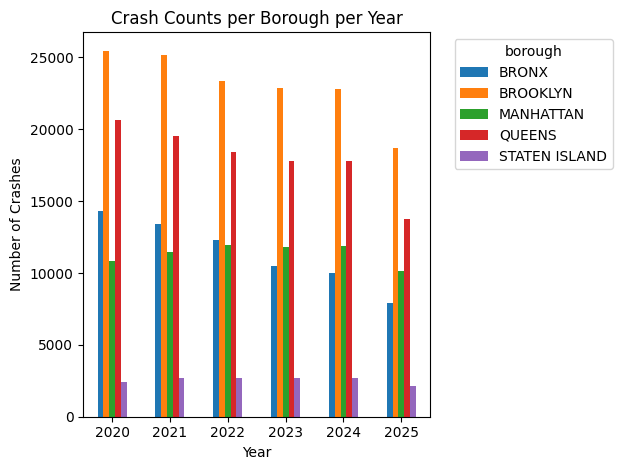

In [ ]:
# determine crash counts per year per borough with the updated data set

from pyspark.sql.functions import date_trunc, col, year
import matplotlib.pyplot as plt


nearest_weather = nearest_weather_clean

# crash counts per hour per borough
crash_counts = (
    nearest_weather
    .withColumn("hour", date_trunc("hour", col("crash_datetime")))
    .groupBy("hour", "borough")
    .count()
    .withColumnRenamed("count", "crash_count")
)

crash_counts_year = crash_counts.withColumn("year", year(col("hour")))

# total crashes per borough per year
crash_by_borough_year = (
    crash_counts_year
    .groupBy("year", "borough")
    .sum("crash_count")
    .withColumnRenamed("sum(crash_count)", "total_crashes")
    .orderBy("year", "borough")
)


pdf = crash_by_borough_year.toPandas()

pivot_df = pdf.pivot(index="year", columns="borough", values="total_crashes").fillna(0)

# plot

plt.figure(figsize=(25, 10))
pivot_df.plot(kind="bar")

plt.title("Crash Counts per Borough per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=0)

plt.legend(title="borough", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
# create table for all boroughs and include hours with 0 crashes and then connect weather features on the hour

weather_hours = nearest_weather.select("weather_datetime").distinct() \
    .withColumnRenamed("weather_datetime", "hour")

boroughs = nearest_weather.select("borough").distinct()

from pyspark.sql.functions import broadcast

full_grid = weather_hours.crossJoin(broadcast(boroughs))

from pyspark.sql.functions import coalesce, lit

grid_with_counts = (
    full_grid
    .join(crash_counts, ["hour", "borough"], "left")
    .withColumn("crash_count", coalesce(col("crash_count"), lit(0)))
)


In [ ]:
# encode weather conditions to run through regression and build features vector

weather_base = nearest_weather.select(
    "weather_datetime", "temp", "feelslike", "humidity", "dew",
    "precip", "snow", "snowdepth", "windspeed", "winddir",
    "pressure", "visibility", "cloudcover", "conditions"
).distinct().withColumnRenamed("weather_datetime", "hour")

grid_final = grid_with_counts.join(weather_base, "hour", "left")

from pyspark.sql.functions import lower, instr, when

grid_model = (
    grid_final
    .withColumn("conditions_lower", lower(col("conditions")))
    .withColumn("cond_rain",      when(instr(col("conditions_lower"), "rain") > 0, 1.0).otherwise(0.0))
    .withColumn("cond_snow",      when(instr(col("conditions_lower"), "snow") > 0, 1.0).otherwise(0.0))
    .withColumn("cond_cloudy",    when(instr(col("conditions_lower"), "cloud") > 0, 1.0).otherwise(0.0))
    .withColumn("cond_overcast",  when(instr(col("conditions_lower"), "overcast") > 0, 1.0).otherwise(0.0))
    .withColumn("cond_clear",     when(instr(col("conditions_lower"), "clear") > 0, 1.0).otherwise(0.0))
    .drop("conditions_lower")
)

from pyspark.sql.functions import hour, dayofweek, month

grid_model = (
    grid_model
    .withColumn("hour_of_day", hour(col("hour")))
    .withColumn("day_of_week", dayofweek(col("hour")))
    .withColumn("month_of_year", month(col("hour")))
)

numeric_features = [
    "temp", "feelslike", "humidity", "dew", "precip",
    "snow", "snowdepth", "windspeed", "winddir",
    "pressure", "visibility", "cloudcover",
    "hour_of_day", "day_of_week", "month_of_year",
    "cond_rain", "cond_snow", "cond_cloudy",
    "cond_overcast", "cond_clear"
]


from pyspark.sql.functions import col, lit

grid_model_filled = grid_model.fillna(numeric_fill)

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features"
)


In [ ]:
# fit poisson regression model

from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(
    family="poisson",
    link="log",
    labelCol="crash_count",
    featuresCol="features"
)

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, glr])
model = pipeline.fit(grid_model)


In [ ]:
# model coefficients and intercept

glr_model = model.stages[-1]
print("Coefficients:", glr_model.coefficients)
print("Intercept:", glr_model.intercept)


Coefficients: [0.003884010483729447,0.0025788867555623612,-0.0052867077976859675,-0.001332307355296048,-0.09997108565181302,0.048074155343264195,0.01458272981477406,0.013363476832190808,-1.606945935140622e-05,0.003864555073278766,-0.02766511668703344,0.0012410168232987488,0.022504021823931193,0.01693037063703484,0.0019142623997000345,0.1141408039426101,0.0951477429626665,-0.22223842163492236,-0.2897104586802881,-0.22259085066235357]
Intercept: -3.501301480412132


In [ ]:
# predictors

glr_model = model.stages[-1]
coeffs = glr_model.coefficients
intercept = glr_model.intercept

import pandas as pd

coef_df = pd.DataFrame({
    "feature": numeric_features,
    "coefficient": coeffs
})

coef_df_sorted = coef_df.sort_values("coefficient", ascending=False)
coef_df_sorted


,feature,coefficient
15,cond_rain,0.114141
16,cond_snow,0.095148
5,snow,0.048074
12,hour_of_day,0.022504
13,day_of_week,0.016930
6,snowdepth,0.014583
7,windspeed,0.013363
0,temp,0.003884
9,pressure,0.003865
1,feelslike,0.002579


In [ ]:
# determine risk multipliers

import numpy as np

coef_df_sorted["risk_multiplier"] = np.exp(coef_df_sorted["coefficient"])
coef_df_sorted["percent_change"] = (coef_df_sorted["risk_multiplier"] - 1) * 100

coef_df_sorted

,feature,coefficient,risk_multiplier,percent_change
15,cond_rain,0.114141,1.120910,12.090994
16,cond_snow,0.095148,1.099821,9.982133
5,snow,0.048074,1.049248,4.924846
12,hour_of_day,0.022504,1.022759,2.275915
13,day_of_week,0.016930,1.017075,1.707450
6,snowdepth,0.014583,1.014690,1.468958
7,windspeed,0.013363,1.013453,1.345317
0,temp,0.003884,1.003892,0.389156
9,pressure,0.003865,1.003872,0.387203
1,feelslike,0.002579,1.002582,0.258221


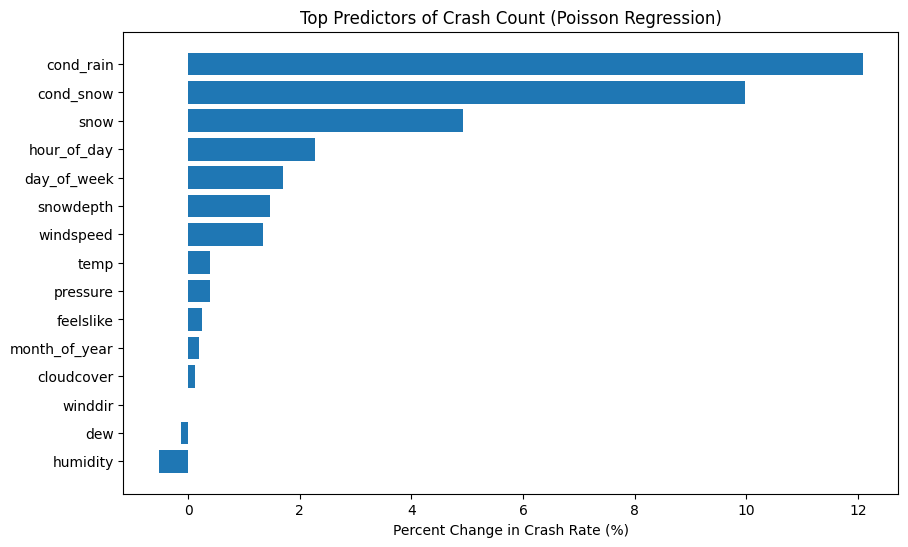

In [ ]:
# predictor effects plot

import matplotlib.pyplot as plt

top_n = 15

plt.figure(figsize=(10, 6))
plt.barh(
    coef_df_sorted["feature"].head(top_n),
    coef_df_sorted["percent_change"].head(top_n)
)
plt.gca().invert_yaxis()
plt.xlabel("Percent Change in Crash Rate (%)")
plt.title("Top Predictors of Crash Count (Poisson Regression)")
plt.show()


Null Deviance: 480378.687204759
Residual Deviance: 458604.3894071543
AIC: 891344.2892860523
Mean: 2.3903053874963986
Variance: 2.684476263225726
Overdispersion ratio: 1.123068323097176


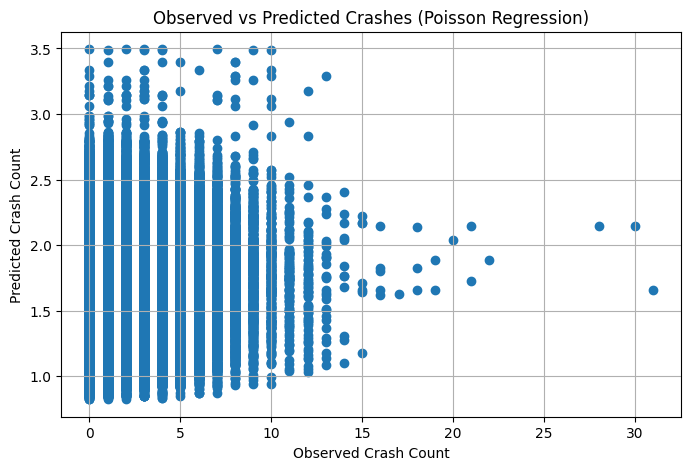

In [ ]:
# poisson model evaluation

summary = glr_model.summary
print("Null Deviance:", summary.nullDeviance)
print("Residual Deviance:", summary.deviance)
print("AIC:", summary.aic)

import numpy as np
pred_mean = np.mean(crash_pd["crash_count"])
pred_var = np.var(crash_pd["crash_count"])

print("Mean:", pred_mean)
print("Variance:", pred_var)
print("Overdispersion ratio:", pred_var / pred_mean)


predictions = model.transform(grid_model_filled).toPandas()

plt.figure(figsize=(8,5))
plt.scatter(predictions["crash_count"], predictions["prediction"])
plt.xlabel("Observed Crash Count")
plt.ylabel("Predicted Crash Count")
plt.title("Observed vs Predicted Crashes (Poisson Regression)")
plt.grid(True)
plt.show()



Average crashes per hour (λ): 2.3903053874963986


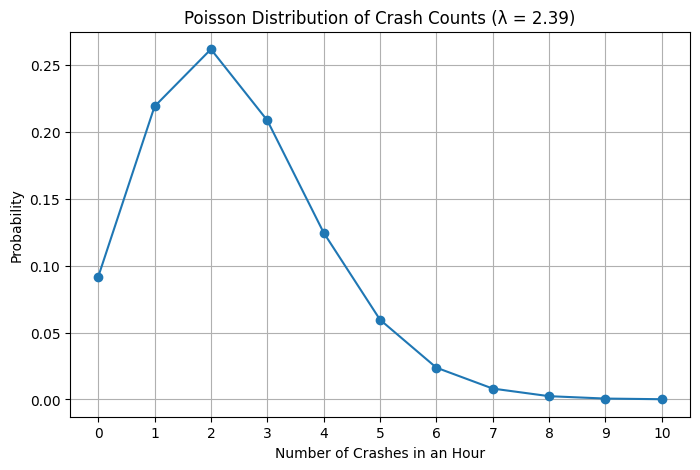

In [ ]:
# plot poisson distribution

import numpy as np
import matplotlib.pyplot as plt
from math import exp, factorial
from pyspark.sql.functions import avg, col

lambda_value = crash_counts.select(avg(col("crash_count"))).first()[0]

print("Average crashes per hour (λ):", lambda_value)


def poisson(k, lam):
    return (lam**k * exp(-lam)) / factorial(k)

k_values = np.arange(0, 11)


probabilities = [poisson(k, lambda_value) for k in k_values]

plt.figure(figsize=(8, 5))
plt.plot(k_values, probabilities, marker="o")

plt.title(f"Poisson Distribution of Crash Counts (λ = {lambda_value:.2f})")
plt.xlabel("Number of Crashes in an Hour")
plt.ylabel("Probability")
plt.xticks(k_values)
plt.grid(True)

plt.show()



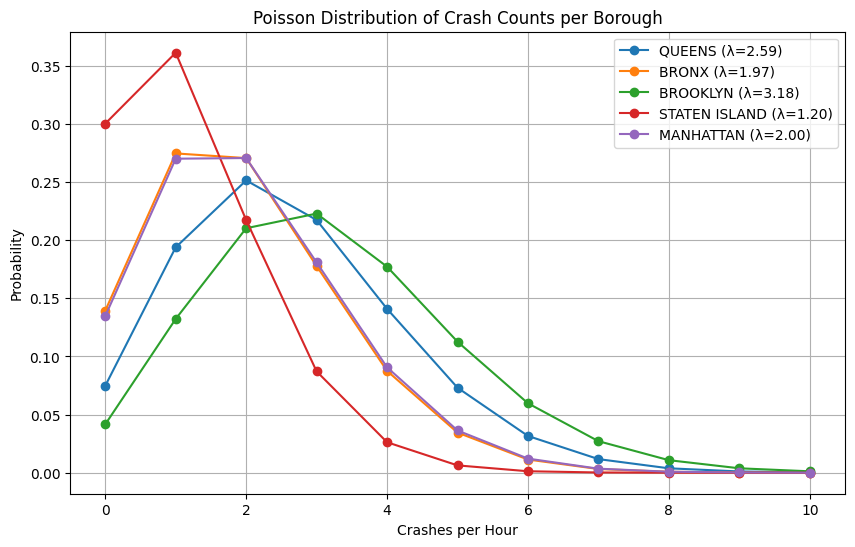

In [ ]:
# poisson curve for each borough

import numpy as np
import matplotlib.pyplot as plt
from math import exp, factorial
import pandas as pd

crash_pd = crash_counts.toPandas()

def poisson(k, lam):
    return (lam**k * exp(-lam)) / factorial(k)

boroughs = crash_pd["borough"].unique()
k_values = np.arange(0, 11)

plt.figure(figsize=(10, 6))

for b in boroughs:
    lam = crash_pd[crash_pd["borough"] == b]["crash_count"].mean()
    pmf = [poisson(k, lam) for k in k_values]
    plt.plot(k_values, pmf, marker="o", label=f"{b} (λ={lam:.2f})")

plt.title("Poisson Distribution of Crash Counts per Borough")
plt.xlabel("Crashes per Hour")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


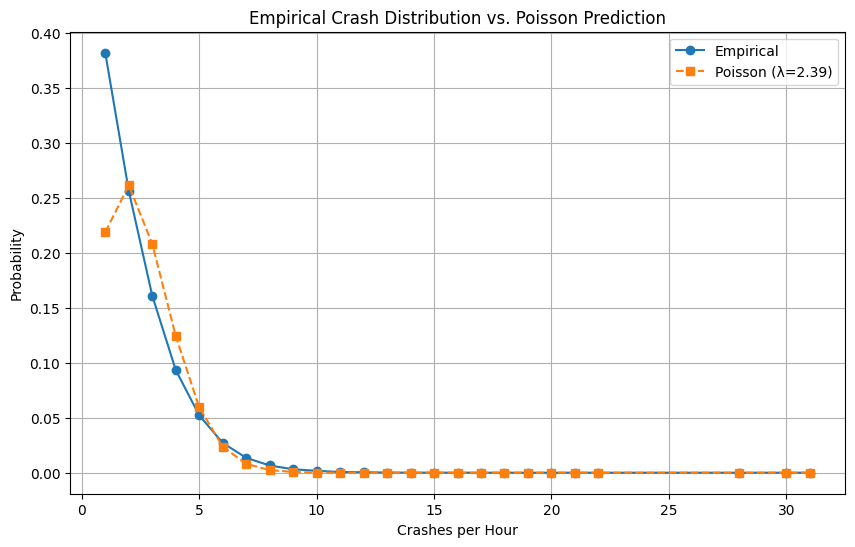

In [ ]:
# empirical crash distribution vs. poisson predicted

lam = crash_pd["crash_count"].mean()

empirical_counts = crash_pd["crash_count"].value_counts(normalize=True).sort_index()

poisson_pred = [poisson(k, lam) for k in empirical_counts.index]

plt.figure(figsize=(10, 6))
plt.plot(empirical_counts.index, empirical_counts.values, "o-", label="Empirical")
plt.plot(empirical_counts.index, poisson_pred, "s--", label=f"Poisson (λ={lam:.2f})")

plt.title("Empirical Crash Distribution vs. Poisson Prediction")
plt.xlabel("Crashes per Hour")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()


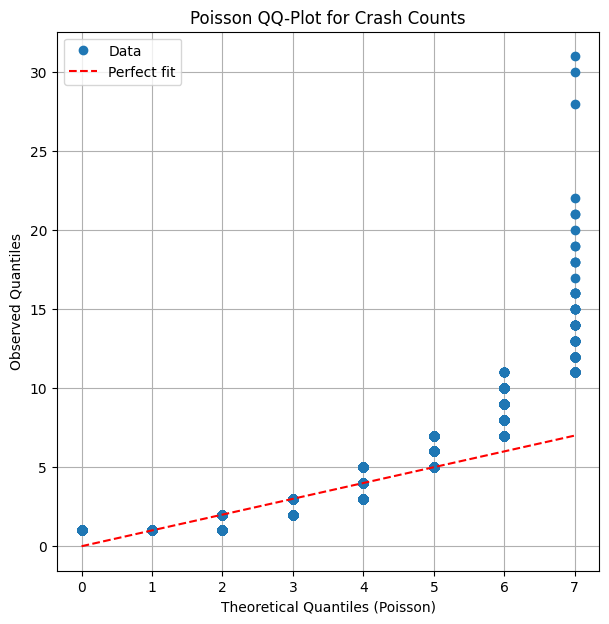

In [ ]:
# QQ Plot

import scipy.stats as stats

observed = crash_pd["crash_count"].values

lam = crash_pd["crash_count"].mean()
theoretical = stats.poisson.ppf(np.linspace(0.01, 0.99, len(observed)), lam)


observed_sorted = np.sort(observed)
theoretical_sorted = np.sort(theoretical)

plt.figure(figsize=(7, 7))
plt.plot(theoretical_sorted, observed_sorted, "o", label="Data")
plt.plot(theoretical_sorted, theoretical_sorted, "r--", label="Perfect fit")

plt.title("Poisson QQ-Plot for Crash Counts")
plt.xlabel("Theoretical Quantiles (Poisson)")
plt.ylabel("Observed Quantiles")
plt.legend()
plt.grid(True)
plt.show()


# Other Distributions of Crash Data

Using reduced *nearest_weather_clean* dataset

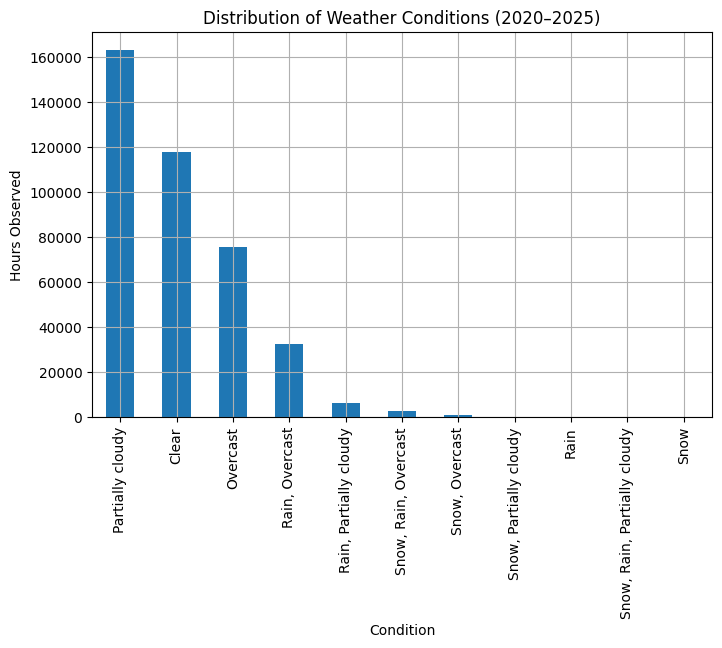

In [ ]:
# weather condition distribution

weather_pd = nearest_weather_clean.select("conditions").toPandas()

plt.figure(figsize=(8,5))
weather_pd["conditions"].value_counts().plot(kind="bar")
plt.title("Distribution of Weather Conditions (2020–2025)")
plt.xlabel("Condition")
plt.ylabel("Hours Observed")
plt.grid(True)
plt.show()


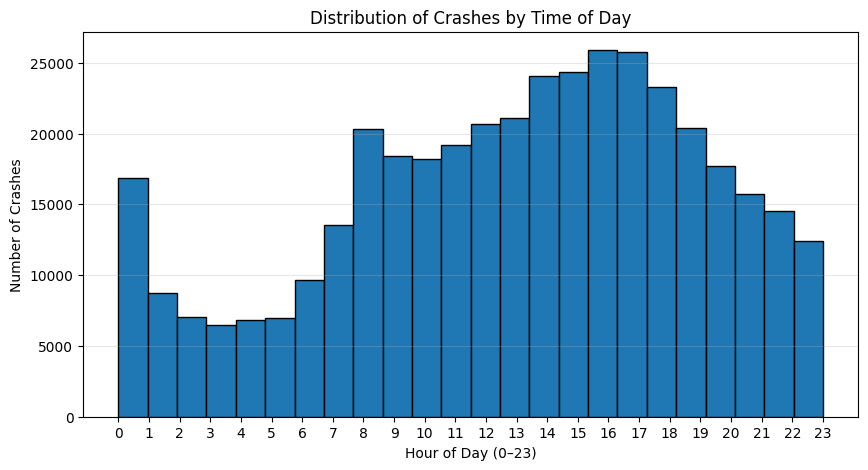

In [ ]:
# crash count distribution by hour of day

import matplotlib.pyplot as plt
from pyspark.sql.functions import hour, col

hourly = nearest_weather_clean.withColumn(
    "hour_of_day", hour(col("crash_datetime"))
)

hourly_pd = hourly.select("hour_of_day").toPandas()

plt.figure(figsize=(10, 5))
plt.hist(hourly_pd["hour_of_day"], bins=24, edgecolor="black")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Crashes")
plt.title("Distribution of Crashes by Time of Day")
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.show()


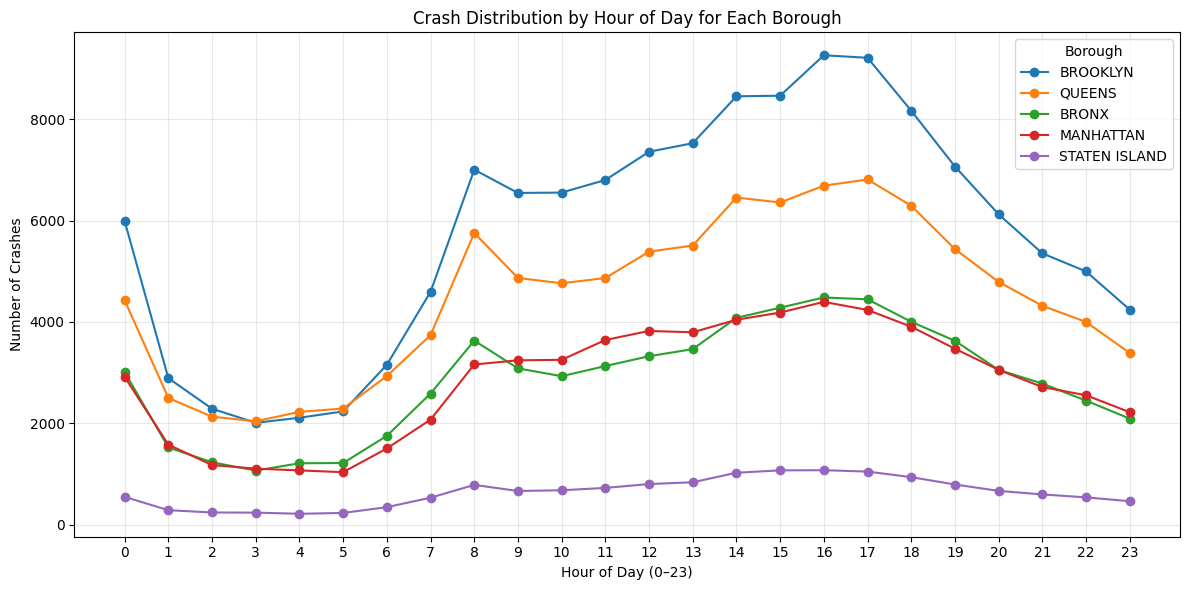

In [ ]:
# crash count distribution by borough (hour of day)

import matplotlib.pyplot as plt
from pyspark.sql.functions import hour, col

hourly = nearest_weather_clean.withColumn(
    "hour_of_day", hour(col("crash_datetime"))
)

hourly_pd = hourly.select("hour_of_day", "borough").toPandas()

plt.figure(figsize=(12, 6))

boroughs = hourly_pd["borough"].unique()

for b in boroughs:
    subset = hourly_pd[hourly_pd["borough"] == b]
    counts = subset["hour_of_day"].value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker="o", label=b)

plt.title("Crash Distribution by Hour of Day for Each Borough")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Crashes")
plt.xticks(range(0, 24))
plt.legend(title="Borough")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
